In [2]:
import os
import sys
sys.path.insert(0, "..")
os.chdir("..")

In [14]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

sys_rand = random.SystemRandom()

In [17]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

In [4]:
ce = torch.nn.CrossEntropyLoss()

In [6]:
targets = torch.randint(low=0, high=20, size=(1, 1, 224, 224))

In [8]:
outputs = torch.randn(1, 21, 224, 224)

In [18]:
cross_entropy2d(outputs, targets)

tensor(3.5004)

In [25]:
arr_sigma = np.load("logs/2023-02-22 19:41:21.903083/batch_preds/epoch_11/predicted_array_sigma.npy")
arr_thresh = np.load("logs/2023-02-22 19:41:21.903083/batch_preds/epoch_11/predicted_array_thresh.npy")
X = np.load("logs/2023-02-22 19:41:21.903083/batch_preds/epoch_11/X.npy")
y_true = np.load("logs/2023-02-22 19:41:21.903083/batch_preds/epoch_11/y_true.npy")

In [26]:
arr_sigma.shape, arr_thresh.shape, X.shape, y_true.shape

((1, 20, 224, 224), (1, 20, 224, 224), (1, 3, 224, 224), (1, 20, 224, 224))

In [24]:
np.unique(arr_sigma[0][13]).min(), np.unique(arr_sigma[0][13]).max()

(2.6031455e-11, 0.07841358)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


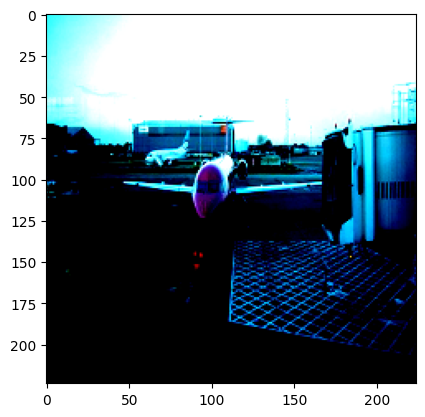

0


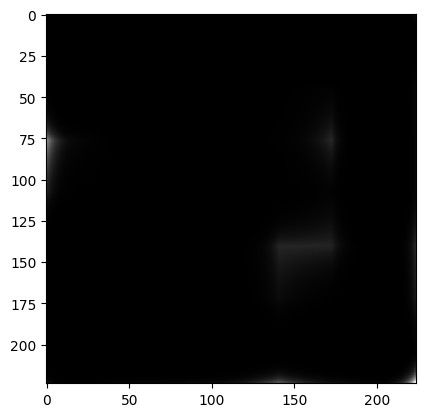

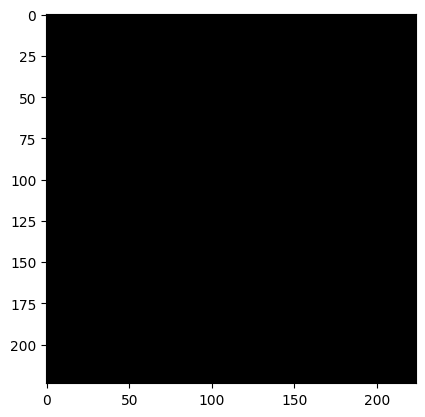

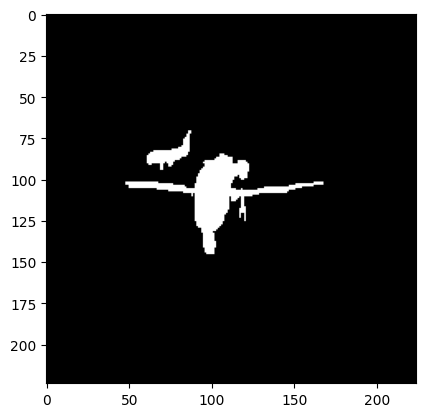

14


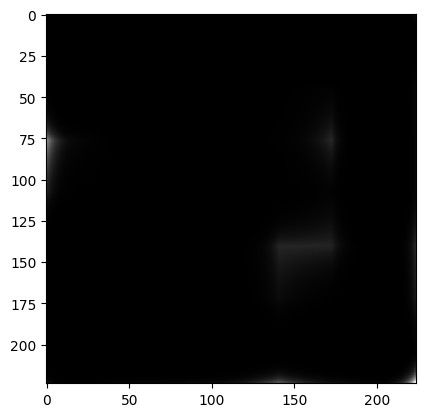

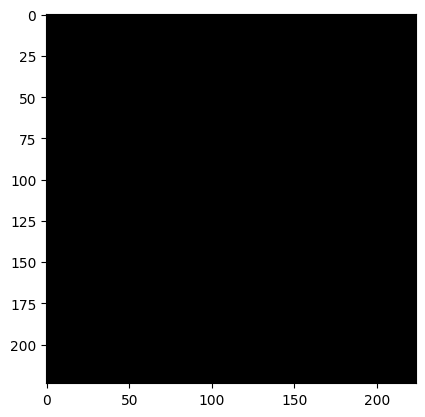

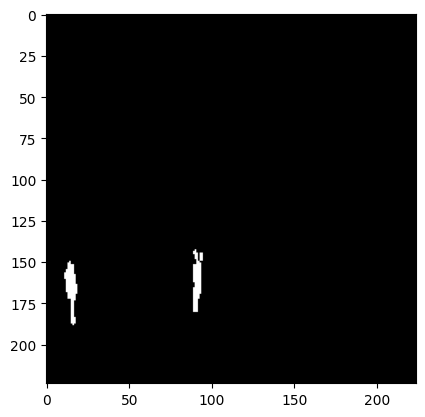

In [27]:
plt.imshow(X[0].transpose(1, 2, 0))
plt.show()

for i in range(20):
    if y_true[0, i, :, :].any():
        print(i)
        plt.imshow(arr_sigma[0][i], cmap="gray")
        plt.show()
        plt.imshow(arr_thresh[0][i], cmap="gray")
        plt.show()
        plt.imshow(y_true[0, i, :, :], cmap="gray")
        plt.show()

In [33]:
import torch
from source.datasets.utils import VOC_CLASSES


IMAGENET_MEANS = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(len(VOC_CLASSES))


def show_image(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def show_image_with_masks(image, mask) -> None:
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(1, 2, 0)
        image = ((image * IMAGENET_STD + IMAGENET_MEANS) * 255).astype(np.uint8)
    if isinstance(mask, torch.Tensor):
        print(torch.unique(mask * 255))
        mask = mask.numpy().transpose(1, 2, 0)
        mask = (255 * mask).astype(np.uint8)
    _, axs = plt.subplots(nrows=2, ncols=11, figsize=(16, 4))
    axs[0, 0].imshow(image)
    axs[0, 0].axis("off")
    axs[0, 0].set_title("Source image")
    t = VOC_CLASSES[1:]
    for i in range(1, len(t) + 1):
        row = i // 11
        col = i % 11
        axs[row, col].imshow(mask[:, :, i-1], cmap="gray")
        axs[row, col].axis("off")
        axs[row, col].set_title(t[i-1])
    plt.tight_layout()
    plt.show()

21


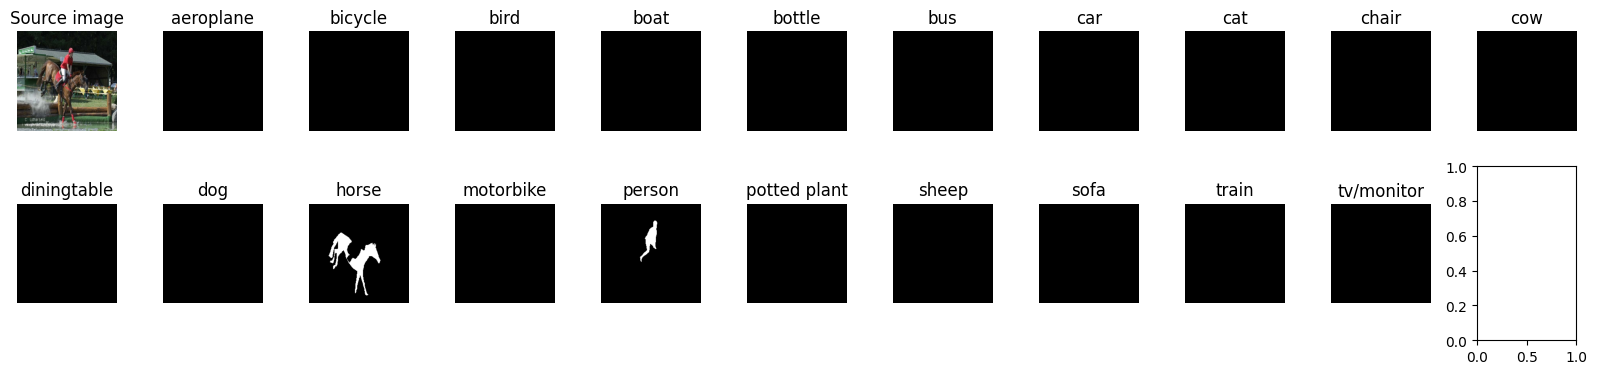

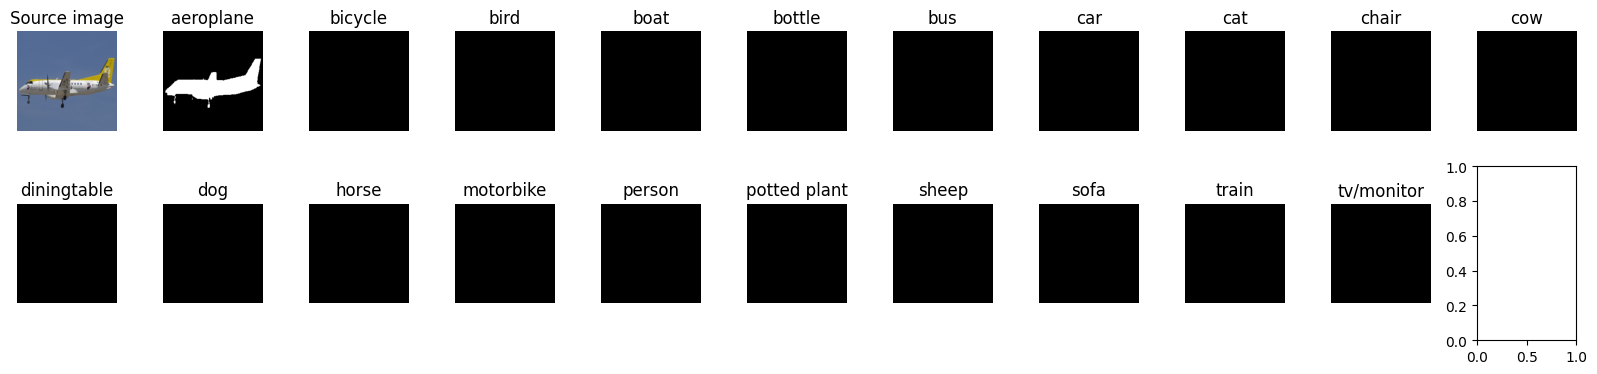

In [13]:
from source.utils.general import read_config
from source.datasets import VOCSegmentation


config = read_config("config.yml")
dataset = VOCSegmentation(config, "train", None)
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

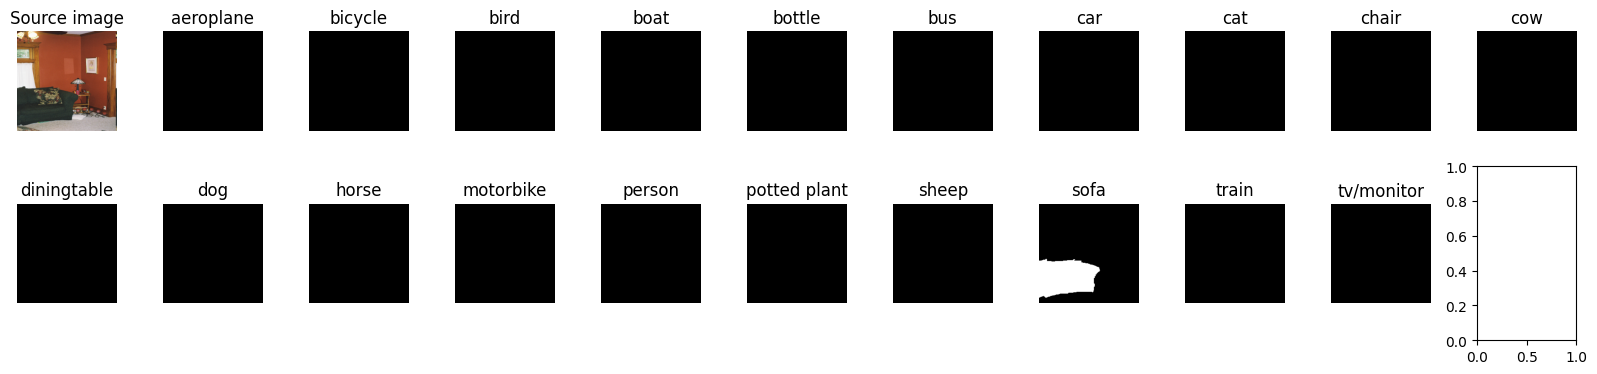

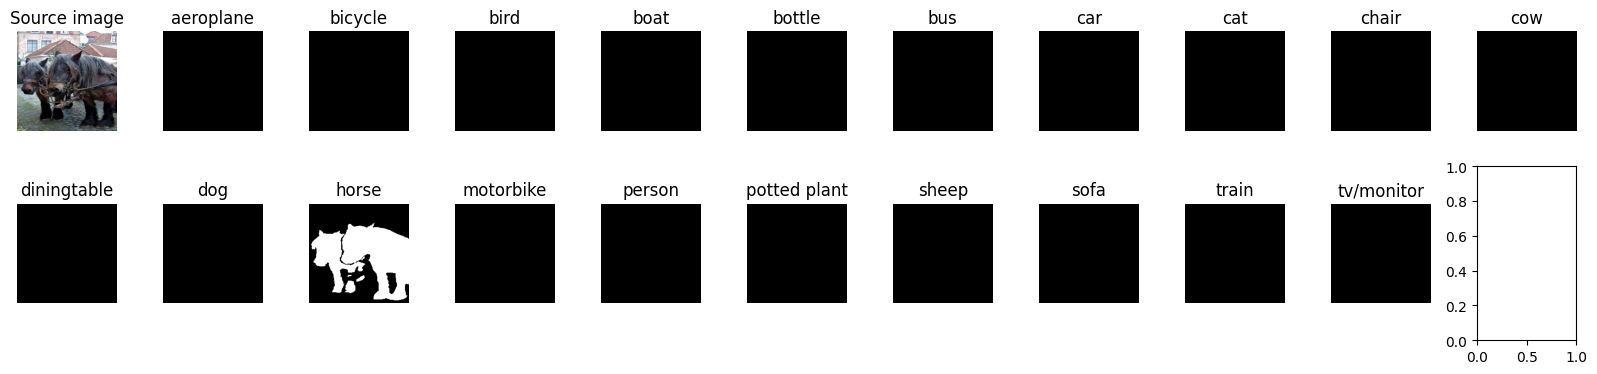

In [14]:
dataset = VOCSegmentation(config, "val", None)
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

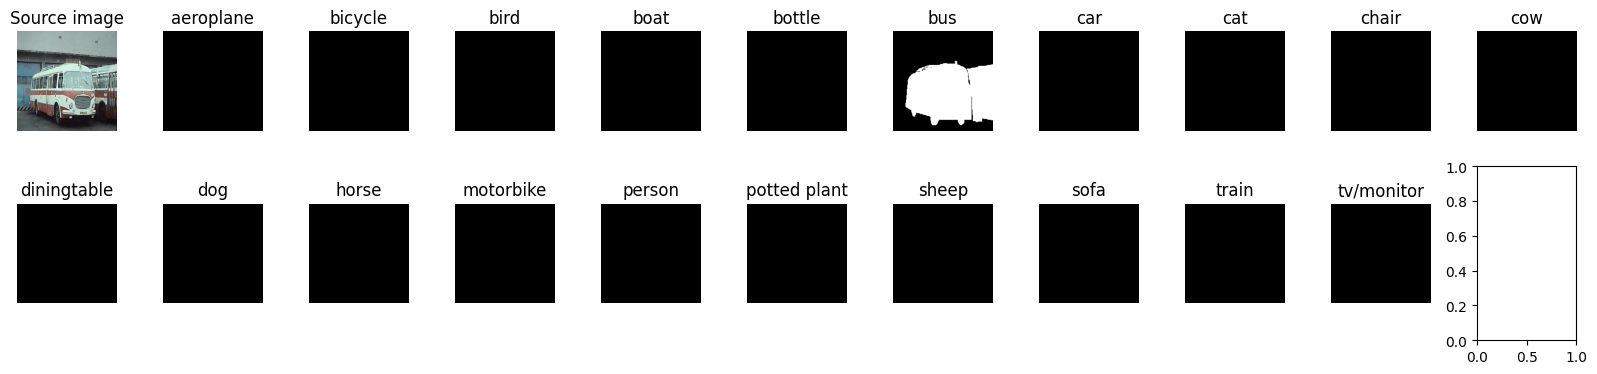

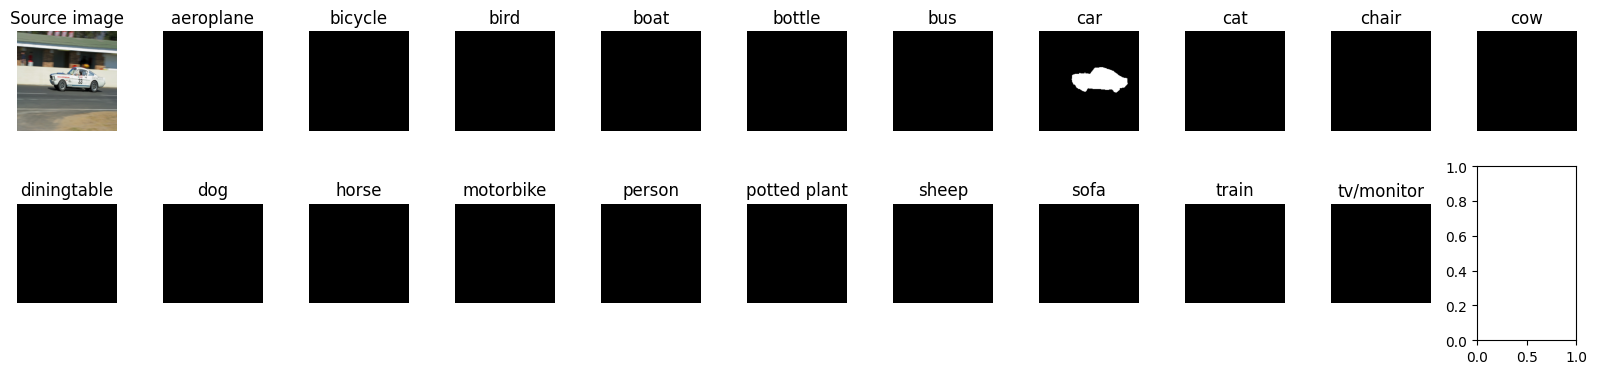

In [15]:
from source.utils.augmentations import get_albumentation_augs


dataset = VOCSegmentation(config, "train", get_albumentation_augs(config)["train"])
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

In [55]:
dataset = VOCSegmentation(config, "val", get_albumentation_augs(config)["val"])
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

tensor([0., 1.])
tensor([0., 1.])


In [51]:
from source.models import FCN32VGG16

model = FCN32VGG16(config)
model.load_state_dict(torch.load("logs/2023-02-22 11:24:05.879670/weights/fcn_2023-02-22 14:08:13.586987_0.06725.pt"))

<All keys matched successfully>

In [52]:
device = torch.device("cpu")
model = model.to(device)
model.eval();

In [ ]:
dataset = VOCSegmentation(config, "val", get_albumentation_augs(config)["val"])
random_indices = range(200)
for idx in random_indices:
    image, masks = dataset[idx]
    to_infer = image.unsqueeze(dim=0).to(device)
    outputs = model(to_infer)
    outputs = (outputs.squeeze(dim=0).detach().cpu().sigmoid() >= 0.06).to(torch.float)
    show_image_with_masks(image, outputs)

In [61]:
from torchvision.models import alexnet, AlexNet_Weights

In [62]:
anet = alexnet(weights=AlexNet_Weights.DEFAULT);

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/azureuser/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


In [63]:
anet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 